In [1]:
#imports
import pandas as pd
from pandas import DataFrame
from pandas import concat

import numpy as np
from numpy import concatenate
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import *
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras import optimizers

K = tf.keras.backend

import math
import matplotlib.pyplot as plt

import random

random.random()

0.38757950664085505

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var(%dt-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var(%dt)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var(%dt+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def takeSlice(arr, fr, to, name): 
    result = arr[fr:to,:,:]
    print(name + ": start at " + str(fr) + " - shape: " + str(result.shape))
    return result

In [5]:
#creating and plotting the data
totalLength = 1200
#creating some data - we will create a sinus and a sinus * sinus function
shift = 7

# data = np.empty((1,totalLength,2)) #0 to 1199
data = list()

#x for the first sinus
base1 = np.array(range(totalLength))*(30*math.pi/totalLength) #30*pi means 15 complete oscilations
#the first sinus
tmp = np.sin(base1)

# print(data[0, :, 0])
tmp = tmp * [random.random() for _ in range(len(tmp))]
data.append(tmp)
#x for the second sinus - this reflects in a sinus with a different frequency
base2 = 0.8*base1

#the first * the second sinus 
tmp2 = (np.sin(base1)+np.sin(base2))/2
tmp2 = tmp2 * [random.random() for _ in range(len(tmp2))]
data.append(tmp2)

data = np.array(data)
data = data.reshape((data.shape[0], data.shape[1], 1))
print('data: ', data.shape)

data:  (2, 1200, 1)


In [17]:
dataset = []
for datas in data:
#     series_to_supervised(datas, n_in = 150)
    dataset.append(series_to_supervised(datas, n_in = 5).values)

In [20]:
dataset = np.array(dataset)
dataset = dataset.reshape((dataset[0].shape[0], dataset[0].shape[1], 2))

In [25]:
print(dataset[:,-1])

[[ 0.38117152  0.08125913]
 [ 0.39485466  0.39196992]
 [ 0.42524505  0.15916451]
 ...
 [-0.34534163 -0.20777474]
 [-0.08202184 -0.07695874]
 [-0.0362558  -0.02444546]]


In [30]:
trainLength = 700
totalLength = dataset.shape[0]
print(trainLength,totalLength)

700 1195


(700, 5, 2) (700, 2)
(495, 5, 2) (495, 2)


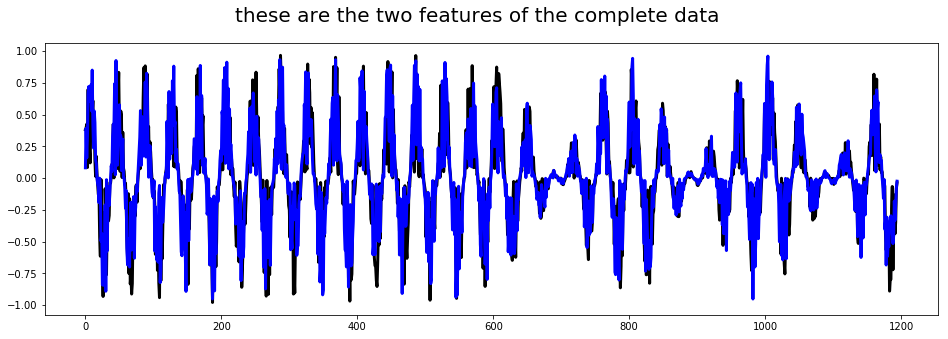

(1195,)


In [36]:
#training data: y is one step ahead of x

y = dataset[:trainLength,-1]
x = dataset[:trainLength,:-1]
print(x.shape, y.shape)
# x = takeSlice(dataset,0,trainLength,'x') #de 0 a 799
# y = takeSlice(dataset,shift,shift+trainLength,'y') #de 7 a 806

#true data for forecasting:
# xForecast = takeSlice(dataset,trainLength,-shift,'xForecast') #de 800 a 1192?
# trueForecast = takeSlice(dataset,shift+trainLength,None,'trueForecast') #de 807 a 1199
trueForecast = dataset[trainLength:,-1]
xForecast = dataset[trainLength:,:-1]
print(xForecast.shape, trueForecast.shape)
# #plotting

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(16,5))
ax.plot(dataset[:,-1,0],color='k',linewidth=3)
ax.plot(dataset[:,-1,1],color='b',linewidth=3)
fig.suptitle('these are the two features of the complete data',fontsize=20)
plt.show()
# print('\n\n\n\n')
print(dataset[:,-1,1].shape)


In [147]:
#creating the model 
K.clear_session()  
model = Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(5,2))) #input takes any steps, two features (var1 and var2)
model.add(LSTM(70,return_sequences=True))
model.add(LSTM(2,return_sequences=False)) #output keeps the steps and has two features
model.add(Lambda(lambda x: x*1.3))
# model.add(Dense(2))

stop = EarlyStopping(monitor='loss',min_delta=0.000000000001,patience=30) #this big patience is important
# rates = [0.001,0.0001,0.00001]
model.compile(loss='mse', optimizer=Adam(lr=0.0001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 100)         41200     
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 70)          47880     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 2)           584       
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 2)           0         
Total params: 89,664
Trainable params: 89,664
Non-trainable params: 0
_________________________________________________________________


In [148]:
model.fit(x,y,epochs=500,callbacks=[stop],verbose=1)

ValueError: Error when checking target: expected lambda_2 to have 3 dimensions, but got array with shape (700, 2)

In [131]:
# model.save('LSTM_good2.h5')
#the model for predictions - copies the other model, but uses `return_sequences=False` and `stateful=True`
#the change is just to allow predicting step by step and using the predictions as new steps. 
# newModel = Sequential()
# newModel.add(LSTM(100,return_sequences=True,stateful=True,batch_input_shape=(1,100,2)))
# newModel.add(LSTM(70,return_sequences=True,stateful=True))
# newModel.add(LSTM(2,return_sequences=False,stateful=True))
# newModel.add(Dense(2))
# newModel.add(Lambda(lambda x: x*1.3))

newModel = Sequential()
newModel.add(LSTM(100,return_sequences=True,input_shape=(5,2))) #input takes any steps, two features (var1 and var2)
newModel.add(LSTM(70,return_sequences=True))
newModel.add(LSTM(2,return_sequences=False)) #output keeps the steps and has two features
newModel.add(Lambda(lambda x: x*1.3))
# newModel.add(Dense(2))

newModel.set_weights(model.get_weights())

In [142]:
newModel.reset_states()
input_predict = xForecast[1]#x[-1]
input_predict = input_predict.reshape((1, input_predict.shape[0], input_predict.shape[1]))
lastSteps = np.zeros((totalLength-trainLength,2))

# print(input_predict)
newModel.predict(x)
# print(lastSteps)
rangeLen = totalLength-trainLength
print('rangeLen: ', rangeLen)
for i in range(rangeLen):
    lastSteps[i] = newModel.predict(input_predict).reshape(1,1,2)
    input_predict = np.concatenate((input_predict, lastSteps[i].reshape(1,1,2)), axis=1)
    input_predict = input_predict[:,1:,:]
    
newModel.reset_states()
print(lastSteps.shape)

rangeLen:  495
(495, 2)


In [143]:
forecastFromSelf = lastSteps
print(forecastFromSelf.shape)

(495, 2)


In [144]:
#predicting from test/future data:
# print(x[-2:-1].shape)
newModel.reset_states()

newModel.predict(x)
newSteps = []
print(xForecast.shape)
for i in range(xForecast.shape[0]):
    newSteps.append(newModel.predict(xForecast[i:i+1,:,:]))

(495, 5, 2)


In [145]:
forecastFromInput = np.asarray(newSteps).reshape(xForecast.shape[0],2)
print(forecastFromInput.shape)

(495, 2)


trueForecast:  (495, 2)
forecastFromInput:  (495, 2)



black line: true values
gold line: predicted values


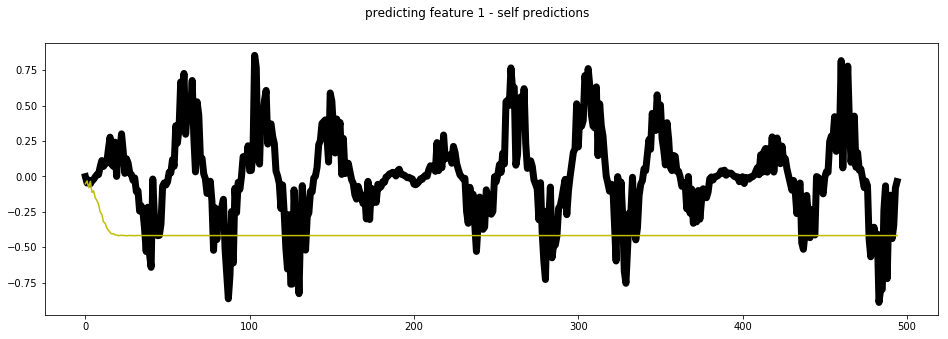

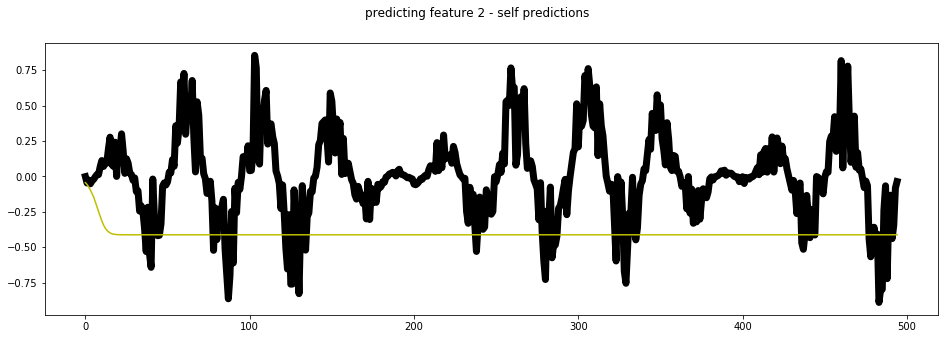

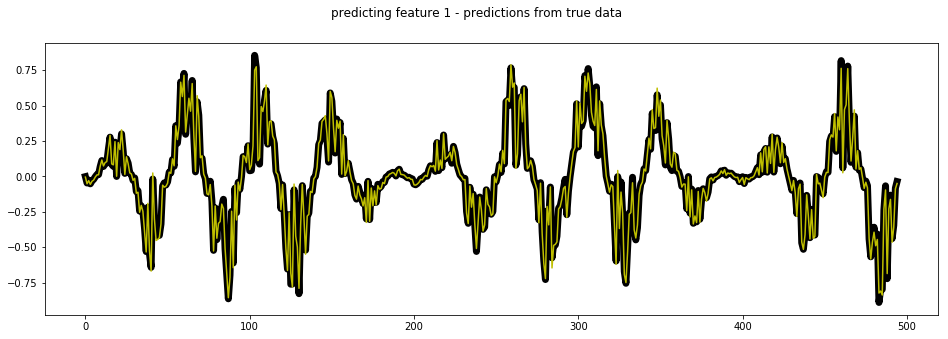

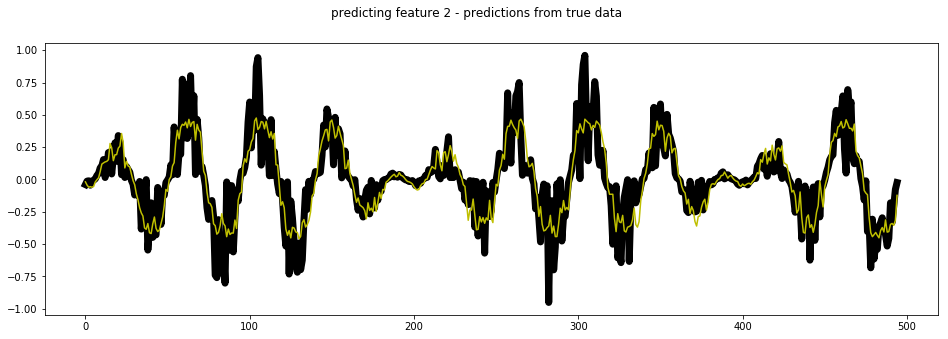

In [146]:
print('trueForecast: ', trueForecast.shape)
# print('forecastFromSelf: ', forecastFromSelf.shape)
print('forecastFromInput: ', forecastFromInput.shape)
print('\n\n\nblack line: true values')
print('gold line: predicted values')


#self forecast
fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(trueForecast[:,0], linewidth=7,color='k') #this uses xForecast because it starts exactly where x ends
ax.plot(forecastFromSelf[:,0],color='y')
plt.suptitle("predicting feature 1 - self predictions")
plt.show()

fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(trueForecast[:,0],linewidth=7,color='k') #this uses xForecast because it starts exactly where x ends
ax.plot(forecastFromSelf[:,1],color='y')
plt.suptitle("predicting feature 2 - self predictions")
plt.show()


#forecast from test/future data:
fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(trueForecast[:,0], linewidth=7,color='k')
ax.plot(forecastFromInput[:,0],color='y')
plt.suptitle("predicting feature 1 - predictions from true data")
plt.show()

fig,ax = plt.subplots(1,1,figsize=(16,5))
ax.plot(trueForecast[:,1],linewidth=7,color='k')
ax.plot(forecastFromInput[:,1],color='y')
plt.suptitle("predicting feature 2 - predictions from true data")
plt.show()